In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
aapl = pd.read_csv('AAPL_CLOSE', index_col = 'Date', parse_dates=True)
csco = pd.read_csv('CISCO_CLOSE', index_col = 'Date', parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE', index_col = 'Date', parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE', index_col = 'Date', parse_dates=True)

In [7]:
stocks = pd.concat([aapl, csco, ibm, amzn], axis=1)
stocks.columns = ['aapl', 'csco', 'ibm', 'amzn']

In [8]:
stocks.head()

,aapl,csco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [9]:
stocks.pct_change(1).mean()

aapl    0.000750
csco    0.000599
ibm     0.000081
amzn    0.001328
dtype: float64

In [10]:
stocks.pct_change(1).corr()

,aapl,csco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
csco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [12]:
stocks.pct_change(1).head()

,aapl,csco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [13]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,csco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


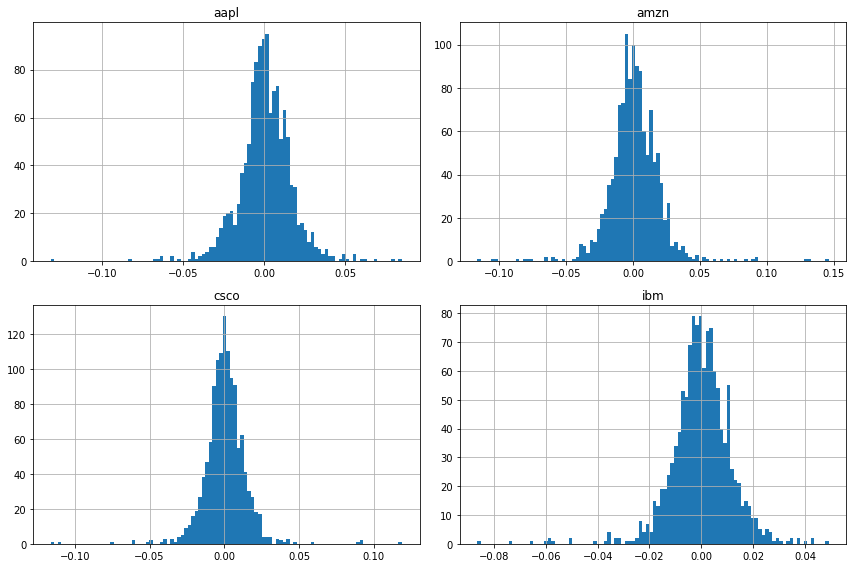

In [14]:
log_ret.hist(bins=100, figsize=(12,8))
plt.tight_layout()

In [15]:
log_ret.mean()

aapl    0.000614
csco    0.000497
ibm     0.000011
amzn    0.001139
dtype: float64

In [17]:
log_ret.cov() * 252

,aapl,csco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
csco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [28]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharp_arr = np.zeros(num_ports)

for ind in range(num_ports):
    


    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)

    # Save Weights
    all_weights[ind,:] = weights
    
    # Expected return 
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)

    # Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights))) # More efficient 

    # Sharp Ratio
    sharp_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [29]:
sharp_arr.max()

1.0303260551271067

In [31]:
sharp_arr.argmax()

1420

In [32]:
all_weights[1420,:]

array([ 0.26188068,  0.20759516,  0.00110226,  0.5294219 ])

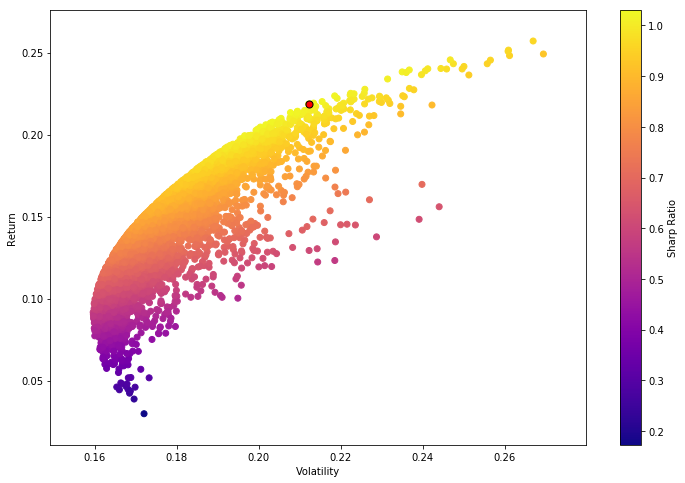

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharp_arr,cmap='plasma')
plt.colorbar(label = 'Sharp Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [36]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [44]:
from scipy.optimize import minimize

In [45]:
# Thing we are trying to minimize

def neg_sharp(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [46]:
# Constraints

def check_sum(weights):
    # returns 0 if the sum is 1 (which is good meaning it is right)
    return np.sum(weights) - 1

In [47]:
cons = ({'type':'eq','fun':check_sum})

In [48]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [49]:
init_guess = [0.25,0.25,0.25,0.25]

In [50]:
opt_results = minimize(neg_sharp,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [51]:
opt_results

     fun: -1.0307168703360359
     jac: array([  5.64157963e-05,   4.18275595e-05,   3.39921713e-01,
        -4.44948673e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  2.66289767e-01,   2.04189819e-01,   6.93482815e-17,
         5.29520414e-01])

In [52]:
opt_results.x

array([  2.66289767e-01,   2.04189819e-01,   6.93482815e-17,
         5.29520414e-01])

In [53]:
get_ret_vol_sr(opt_results.x)

array([ 0.21885916,  0.21233683,  1.03071687])

In [54]:
# Provide the optimial portfolio for the desired risk and return

In [55]:
frontier_y = np.linspace(0,0.3,100)

In [56]:
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

In [ ]:
frontier_vol = []

